In [2]:
import cupy as cp
import numpy as np
from scipy import fft
from cupyx.scipy import fft as fft_gpu
from numba import cuda
import time
import matplotlib.pyplot as plt
import cv2
import skimage.io
from google.colab.patches import cv2_imshow

# Transfering data to the GPU



In [ ]:
#We transfer the matrix (array) from the CPU to the GPU
array_cpu = np.random.randint(0, 255, size = (4000,4000))
array_cpu
print(f"CPU array:")
print(array_cpu)
array_gpu = cp.asarray(array_cpu)
array_gpu
print(f"GPU array:")
print(array_gpu)

CPU array:
[[100 243  95 ... 116 103  54]
 [240 209 192 ... 205  92 229]
 [123  96  62 ... 221 191  31]
 ...
 [240 223 152 ... 122  71 168]
 [ 99  78 179 ...  74 202  99]
 [217  36 129 ... 137 229 176]]
GPU array:
[[100 243  95 ... 116 103  54]
 [240 209 192 ... 205  92 229]
 [123  96  62 ... 221 191  31]
 ...
 [240 223 152 ... 122  71 168]
 [ 99  78 179 ...  74 202  99]
 [217  36 129 ... 137 229 176]]


In [ ]:
%%timeit
cp.asarray(array_cpu) #time it takes for array to be transfered from the CPU to the GPU

39.3 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Fourier transform

In [ ]:
%%timeit
fft.fftn(array_cpu) #how long does fft function on an array take in CPU

435 ms ± 56.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
fft_gpu.fftn(array_gpu) #how long does fft function on an array take in GPU

20.6 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
fft_cpu = fft.fftn(array_cpu)
fft_sent_back = cp.asnumpy(fft_gpu.fftn(array_gpu))
np.allclose(fft_sent_back, fft_cpu) #checking if both arrays are the same

True

# Custom kernels with numba

### Numba kernels

In [5]:
@cuda.jit
def mult(A,B,C):
  i,j = cuda.grid(2)
  if i < C.shape[0] and j < C.shape[1]:
    tmp = 0.
    for k in range(A.shape[1]):
      tmp += A[i, k] * B[k, j]
    C[i, j] = tmp

cp.random.seed(42)
A = cp.random.uniform(1, 10, size=(4000, 4000), dtype = np.float64)
B = cp.random.uniform(1, 10, size=(4000, 4000), dtype = np.float64)
C = cp.zeros((2000, 2000), dtype=np.float64)       # array where we store answer


threadsperblock = (16, 16)  # each block will contain 16x16 threads, typically 128 - 512 threads/block
blockspergrid_x = int(np.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)  # we calculate the gridsize (number of blocks) from array

#execution of the kernel
mult[blockspergrid, threadsperblock](A, B, C)
C

array([[118892.75953542, 118784.78063883, 119746.64202074, ...,
        118924.00412245, 118491.66423218, 118905.82479458],
       [123936.75847014, 122802.5396921 , 124386.12193071, ...,
        123815.84386247, 123211.83682629, 122934.3251113 ],
       [121274.69879463, 120510.13272916, 121074.27294723, ...,
        121310.74950673, 121517.82480492, 121263.84001694],
       ...,
       [120637.44479389, 119763.17151955, 120835.08845449, ...,
        120583.72155752, 120925.55708609, 120154.57739328],
       [122615.63169474, 122210.96428673, 122429.76587048, ...,
        122212.80774356, 122384.4018842 , 122350.51022351],
       [122494.68622031, 120837.30792169, 121609.17232584, ...,
        121824.36461623, 121677.27132961, 121215.23474129]])

In [10]:
#faster multiplication can be obtained by making use of shared memory between threads in the same block
from numba import float32, int32, float64

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

# execution of the kernel
SIZE = 4000
A = cp.random.uniform(1, 10, size=(SIZE, SIZE), dtype=np.float32)
B = cp.random.uniform(1, 10, size=(SIZE, SIZE), dtype=np.float32)
C_slow = cp.zeros((SIZE, SIZE), dtype=np.float32)
C_fast = cp.zeros((SIZE, SIZE), dtype=np.float32)
threadsperblock = (TPB, TPB)
blockspergrid = int(np.ceil(SIZE / threadsperblock[0]))
blockspergrid = (blockspergrid, blockspergrid)

mult[blockspergrid, threadsperblock](A, B, C_slow)
fast_matmul[blockspergrid, threadsperblock](A, B, C_fast)
cp.allclose(C_slow, C_fast)
C_c = cp.dot(A, B)

In [7]:
%%time

for i in range(10):
  mult[blockspergrid, threadsperblock](A, B, C_slow)

CPU times: user 12 s, sys: 8.78 ms, total: 12 s
Wall time: 12 s


In [8]:
%%time

for i in range(10):
  fast_matmul[blockspergrid, threadsperblock](A, B, C_fast)

CPU times: user 10.6 s, sys: 9.32 ms, total: 10.6 s
Wall time: 10.6 s


In [9]:
%time

for i in range(10):
  cp.dot(A, B)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


# Comparing CPU and GPU Matrix Multiplication

To demonstrate the differences between CPU and GPU matrix multiplication, a good example would involve multiplying large matrices and comparing the performance (in terms of execution time) between the two approaches. NumPy will be used for CPU computation and CuPy for GPU computation.


CPU time: 3.7787222862243652 seconds
GPU time: 0.7050599975585937 seconds
Results are approximately the same.


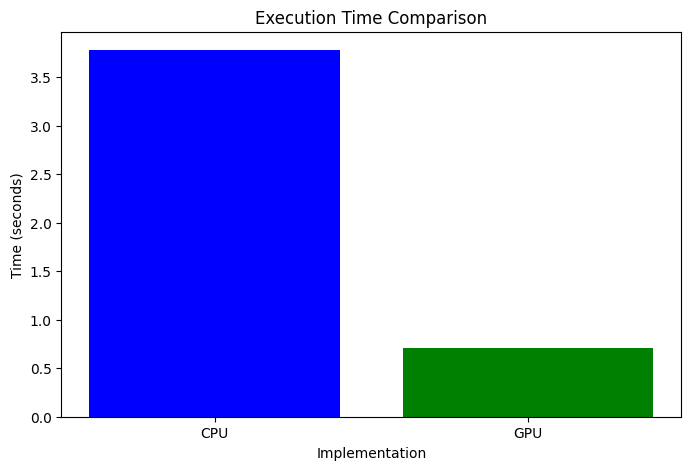

In [ ]:
#define the size of matrices
N = 4000

#create random matrices using numpy
A_cpu = np.random.rand(N,N)
B_cpu = np.random.rand(N,N)

#transfer matrices A and B to GPU using cupy
A_gpu = cp.asarray(A_cpu)
B_gpu = cp.asarray(B_cpu)

#Matrix multiplication on CPU
start_time_cpu = time.time()
C_cpu = np.dot(A_cpu, B_cpu)
end_time_cpu = time.time()
cpu_time = end_time_cpu - start_time_cpu
print(f"CPU time: {cpu_time} seconds")

#Matrix multiplication on GPU
start_time_gpu = cp.cuda.Event()
end_time_gpu = cp.cuda.Event()
start_time_gpu.record()
C_gpu = cp.dot(A_gpu, B_gpu)
end_time_gpu.record()
#Synchronize to wait for the GPU computatuion to finish
end_time_gpu.synchronize()
gpu_time = cp.cuda.get_elapsed_time(start_time_gpu, end_time_gpu) / 1000  # Convert to seconds
print(f"GPU time: {gpu_time:} seconds")

# Optional: Verify that the results are approximately the same
C_cpu = np.array(C_cpu)
C_gpu = cp.asnumpy(C_gpu)

if np.allclose(C_cpu, C_gpu, atol=1e-5):
    print("Results are approximately the same.")
else:
    print("Results differ.")


plt.show()

labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Execution Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()


# Comparing CPU and GPU Image Transformation

To demonstrate the differences between CPU and GPU in image transformations using matrix multiplication, a good example would involve applying a geometric transformation (rotation)
 to a large image and comparing the performance (execution time) between the two approaches. OpenCV will be used for image manipulation, NumPy for CPU computation and CuPy for GPU computatuion.  

CPU time: 3.738304 seconds
GPU time: 0.005050 seconds


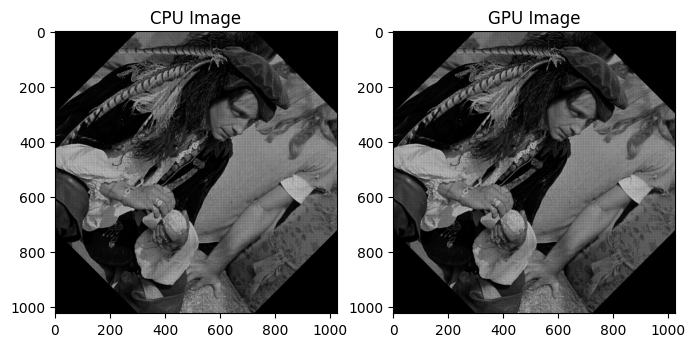

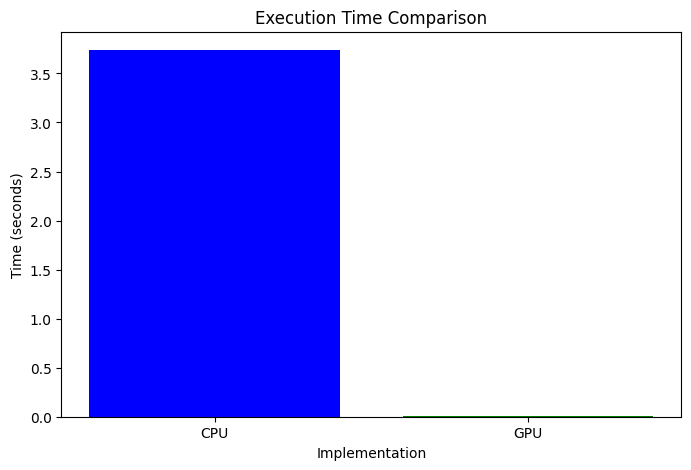

In [15]:
#Function to apply transformation using CPU
def apply_transformation_cpu(image, transformation_matrix):
  rows, cols = image.shape
  transformed_image = np.zeros_like(image)
  for i in range(rows):
    for j in range(cols):
      x, y = np.dot(transformation_matrix, [j,i,1])
      if 0 <= x < cols and 0 <= y < rows:
                transformed_image[int(y), int(x)] = image[i, j]
  return transformed_image

# Function to apply transformation using GPU (CuPy)
def apply_transformation_gpu(image, transformation_matrix):
    image_gpu = cp.asarray(image)
    transformation_matrix_gpu = cp.asarray(transformation_matrix)
    rows, cols = image_gpu.shape

    # Generate a grid of coordinates
    y_coords, x_coords = cp.indices((rows, cols))
    flat_coords = cp.vstack((x_coords.ravel(), y_coords.ravel(), cp.ones(x_coords.size)))

    # Apply the transformation using matrix multiplication on GPU
    transformed_coords = cp.dot(transformation_matrix_gpu, flat_coords)
    transformed_x, transformed_y = transformed_coords[0], transformed_coords[1]

    transformed_x = transformed_x.astype(cp.int32).reshape(rows, cols)
    transformed_y = transformed_y.astype(cp.int32).reshape(rows, cols)

    mask = (0 <= transformed_x) & (transformed_x < cols) & (0 <= transformed_y) & (transformed_y < rows)
    transformed_image_gpu = cp.zeros_like(image_gpu)
    transformed_image_gpu[transformed_y[mask], transformed_x[mask]] = image_gpu[y_coords[mask], x_coords[mask]]

    return cp.asnumpy(transformed_image_gpu)

#Load an image
url = "https://sipi.usc.edu/database/download.php?vol=misc&img=5.3.01"
image = skimage.io.imread(url)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rows, cols = image.shape

#Define the rotation angle
angle = 45
theta = np.radians(angle)
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)

#Define the rotation matrix
rotation_matrix = np.array([[cos_theta, -sin_theta, (1 - cos_theta) * cols / 2 + sin_theta * rows / 2],
    [sin_theta, cos_theta, (1 - cos_theta) * rows / 2 - sin_theta * cols / 2]
])

# Measure time for CPU transformation
start_time_cpu = time.time()
transformed_image_cpu = apply_transformation_cpu(image, rotation_matrix)
end_time_cpu = time.time()
cpu_time = end_time_cpu - start_time_cpu
print(f"CPU time: {cpu_time:.6f} seconds")

# Measure time for GPU transformation
start_time_gpu = cp.cuda.Event()
end_time_gpu = cp.cuda.Event()

start_time_gpu.record()
transformed_image_gpu = apply_transformation_gpu(image, rotation_matrix)
end_time_gpu.record()

# Synchronize to wait for the GPU computation to finish
end_time_gpu.synchronize()

gpu_time = cp.cuda.get_elapsed_time(start_time_gpu, end_time_gpu) / 1000  # Convert to seconds
print(f"GPU time: {gpu_time:.6f} seconds")

# Save and display the results
cv2.imwrite('transformed_image_cpu.jpg', transformed_image_cpu)
cv2.imwrite('transformed_image_gpu.jpg', transformed_image_gpu)

cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.title('CPU Image')
plt.imshow(transformed_image_cpu, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('GPU Image')
plt.imshow(transformed_image_gpu, cmap='gray')

plt.show()


plt.show()

labels = ['CPU', 'GPU']
times = [cpu_time, gpu_time]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Execution Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()